In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib

from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from skimage.measure import label
from skimage.morphology import binary_dilation, closing
from scipy.stats import ttest_ind

from statannotations.Annotator import Annotator

In [2]:
### REPLACE with path to AnnData downloaded from GCP ###
data_dir = '/Users/adaly/Documents/mouse_colon/csplotch_anndata'
adata = sc.read_h5ad(os.path.join(data_dir, 'adata_csplotch_lambdas.h5ad'))

### Fig5a: cellular composition of MROIs across time

In [3]:
# Groups cells of same morphological type together
sntypes_map = {
    'Colonocyte': ['Colonocyte'],
    'Immune': ['B', 'T'],
    'Interstitial': ['Fibroblast', 'Glia', 'Lymphatic', 'Macrophage', 'Mesothelial', 'Neuron', 'Vascular'],
    'Muscle': ['SMC'],
    'Epithelial': ['Cycling', 'Enteroendocrine', 'Goblet', 'Stem', 'TA', 'Tuft']
}
sntypes_ordered = (sntypes_map['Immune'] + sntypes_map['Interstitial'] + 
                   sntypes_map['Muscle'] + sntypes_map['Epithelial'] + sntypes_map['Colonocyte'])

# Set colors for each snRNA-seq cell type, ensuring that those sharing a morphological type are drawn from the same colormap.
colors_ordered = []
for snt in sntypes_ordered:
    if snt == 'Colonocyte':
        cmap = matplotlib.cm.get_cmap('Blues')
        colors_ordered.append(cmap(0.75))
    elif snt == 'SMC':
        cmap = matplotlib.cm.get_cmap('Reds')
        colors_ordered.append(cmap(0.75))
    elif snt == 'B' or snt == 'T':
        cmap = matplotlib.cm.get_cmap('Oranges')
        colors_ordered.append(cmap(0.5 * (sntypes_map['Immune'].index(snt)+1) / len(sntypes_map['Immune'])))
    elif snt in sntypes_map['Interstitial']:
        cmap = matplotlib.cm.get_cmap('Greens')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Interstitial'].index(snt)+1) / len(sntypes_map['Interstitial'])))
    elif snt in sntypes_map['Epithelial']:
        cmap = matplotlib.cm.get_cmap('Purples')
        colors_ordered.append(cmap(0.75 * (sntypes_map['Epithelial'].index(snt)+1) / len(sntypes_map['Epithelial'])))
    else:
        raise ValueError('Unrecognized cell type')

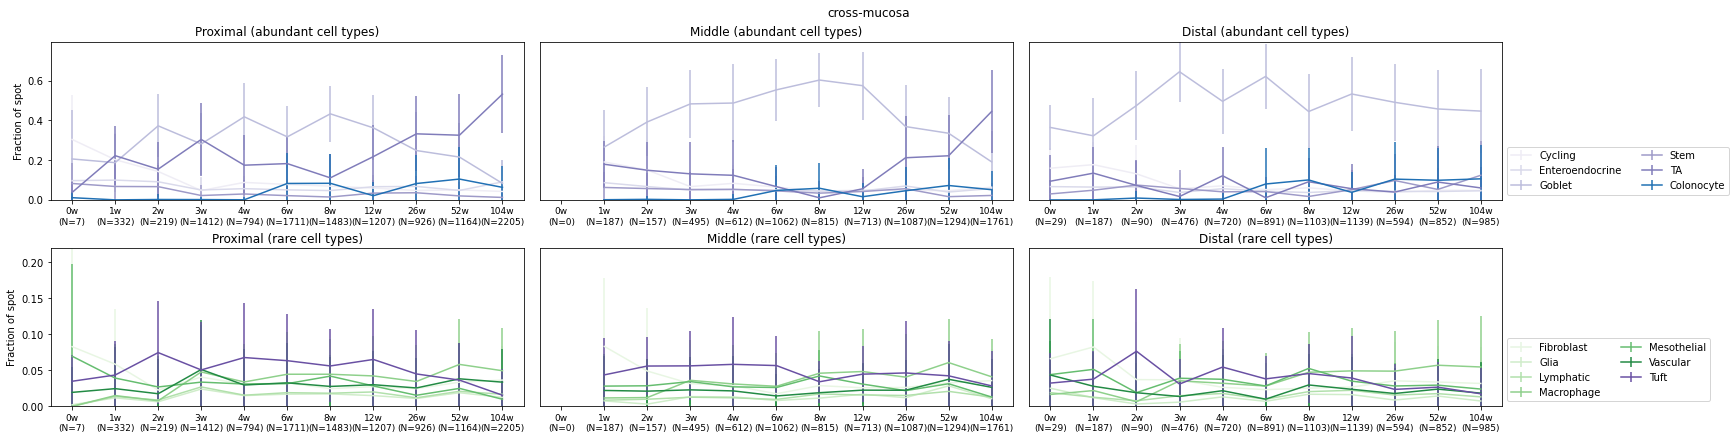

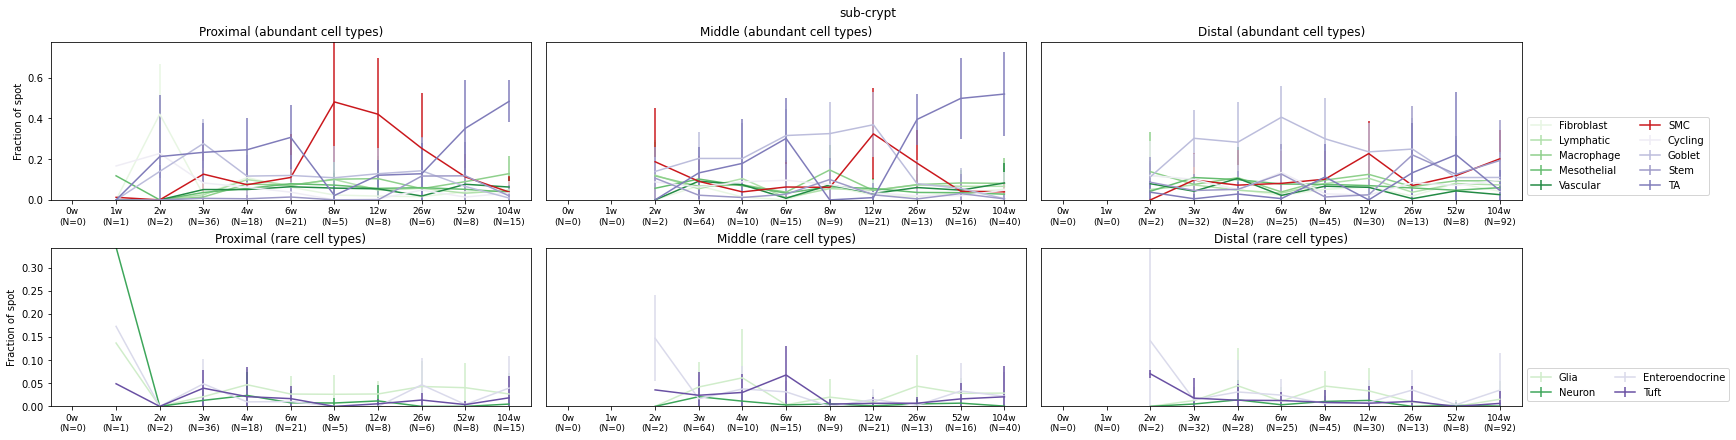

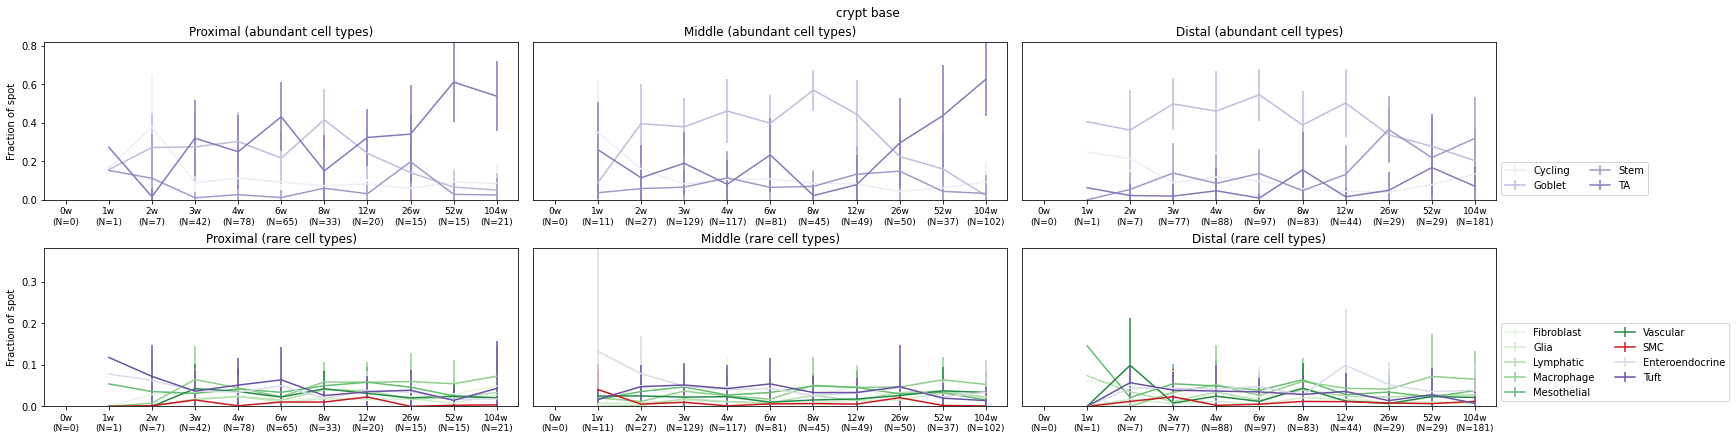

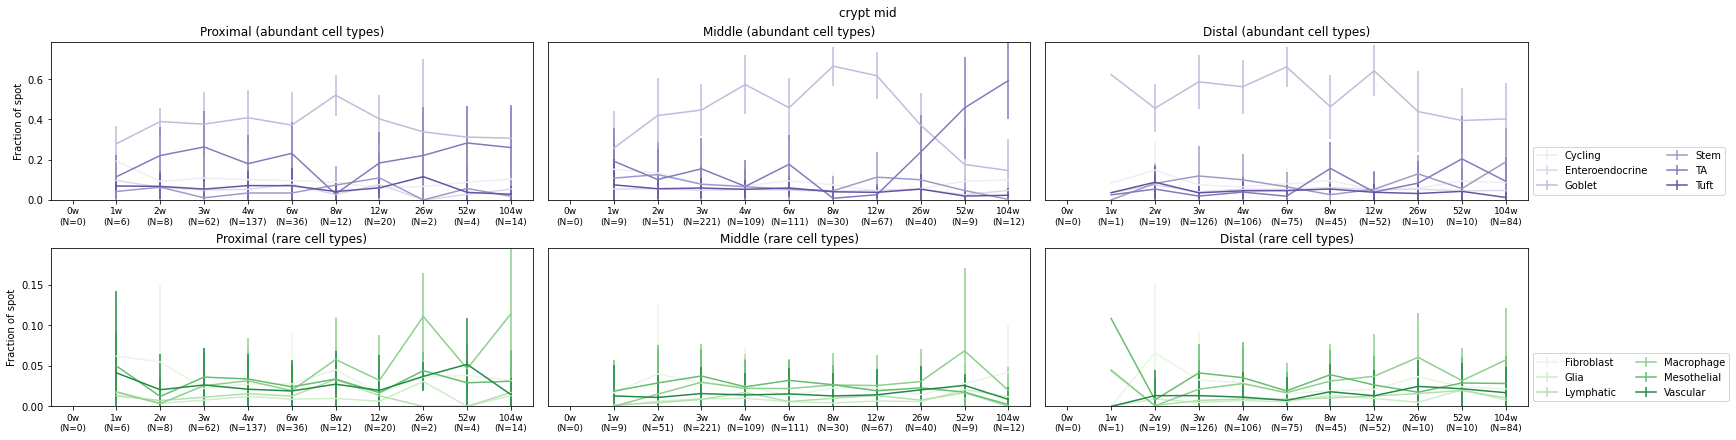

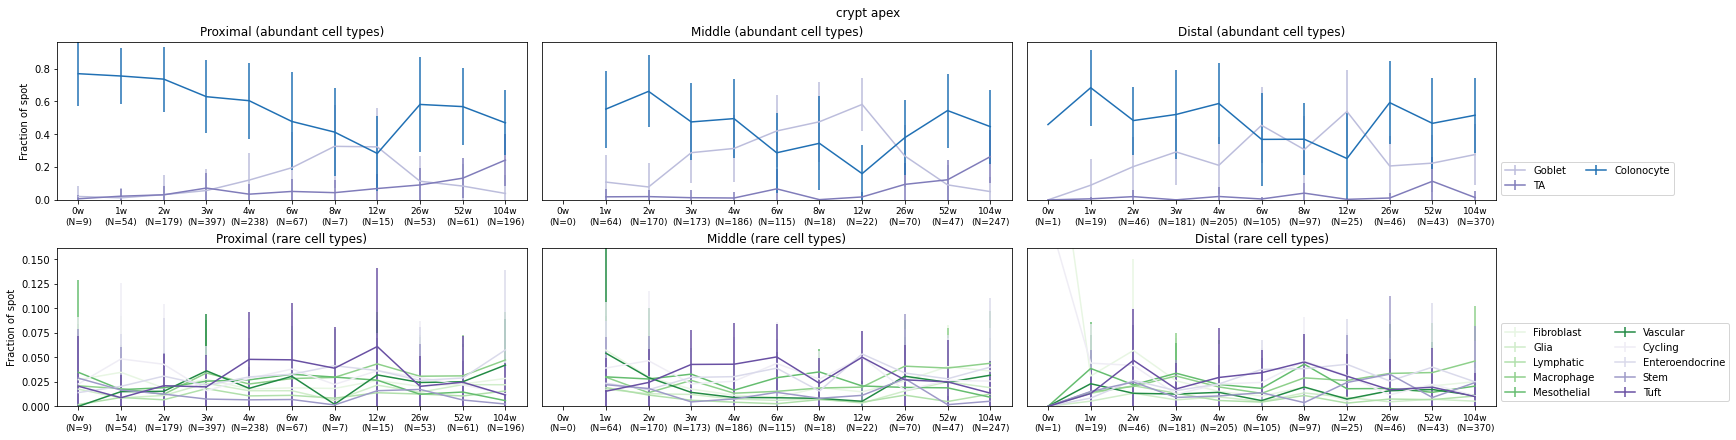

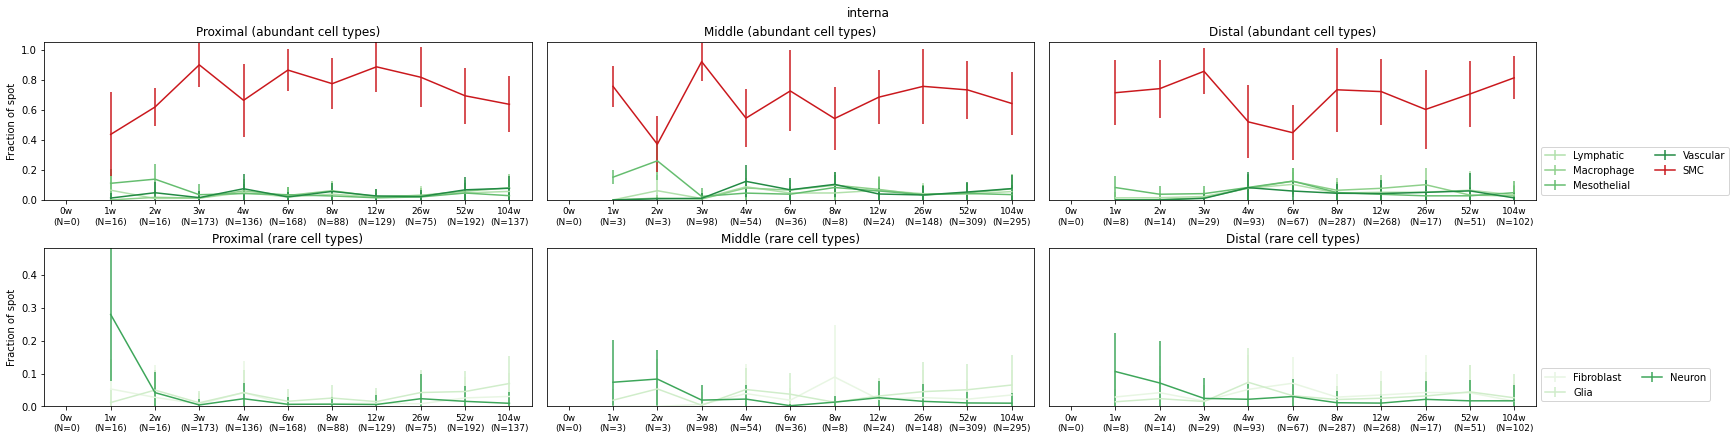

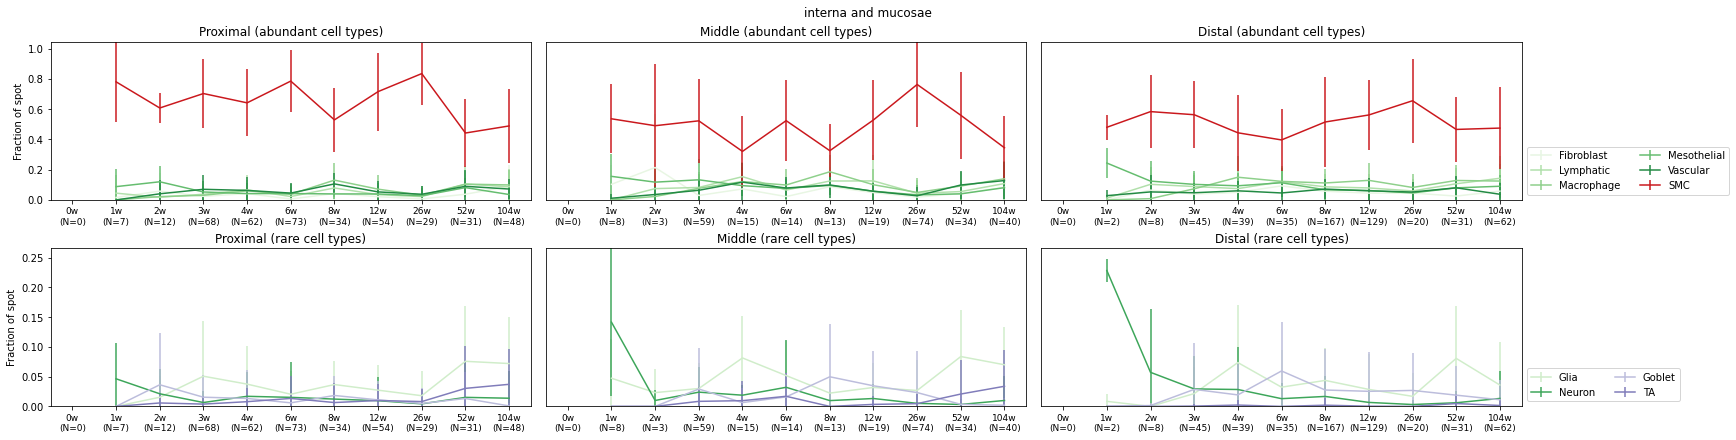

In [5]:
# Proportions of abundant (>5%), rare (1-5%) cell types across full age range

t_ordered = ['0w', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '26w', '52w', '104w']
abundant_thresh = 0.05
rare_thresh = 0.01

for aar in ['cross-mucosa', 'sub-crypt', 'crypt base', 'crypt mid', 'crypt apex',
            'interna', 'interna and mucosae']:
    obs_aar = adata.obs[adata.obs.annotation == aar]
    
    fig, ax = plt.subplots(2, 3, figsize=(24,6), constrained_layout=True)
    
    aar_title = aar
    plt.suptitle(aar_title)
    
    ymax = np.zeros((2,3))
        
    for i, region in enumerate(['Proximal', 'Middle', 'Distal']):
        obs_aar_reg = obs_aar[obs_aar.Region == region]

        celltype_means = dict([(ct, []) for ct in sntypes_ordered])
        celltype_stds = dict([(ct, []) for ct in sntypes_ordered])
        
        x_labels = []

        for t in t_ordered:
            obs_aar_reg_t = obs_aar_reg[obs_aar_reg.Age == t]
            for ct in sntypes_ordered:
                celltype_means[ct].append(obs_aar_reg_t[ct].mean())
                celltype_stds[ct].append(obs_aar_reg_t[ct].std())

            x_labels.append('%s\n(N=%d)' % (t, obs_aar_reg_t.shape[0]))

        for j, thresh in enumerate(['abundant', 'rare']):
            ax[j,i].set_title('%s (%s cell types)' % (region, thresh))

            for ct, col in zip(sntypes_ordered, colors_ordered):
                mean_comp = np.max([obs_aar[ct][obs_aar.Region==r].mean() for r in ['Proximal', 'Middle', 'Distal']])
                
                ct_lbl = ct
                if ct == 'Myocyte':
                    ct_lbl = 'SMC'
                
                if ((thresh == 'abundant' and mean_comp > abundant_thresh) or
                    (thresh == 'rare' and mean_comp > rare_thresh and mean_comp < abundant_thresh)):
                    ax[j,i].errorbar(np.arange(len(t_ordered)), celltype_means[ct], yerr=celltype_stds[ct], 
                                   label=ct_lbl, color=col)
                    
                    inds = np.logical_not(np.isnan(celltype_stds[ct]))
                    mu = np.array(celltype_means[ct])[inds]
                    sigma = np.array(celltype_stds[ct])[inds]
                    ymax[j,i] = np.maximum(ymax[j,i], np.max(mu+sigma))

            ax[j,i].set_xticks(np.arange(len(t_ordered)))
            ax[j,i].set_xticklabels(x_labels, fontsize=9)
            
            if i == 2:
                ax[j,i].legend(bbox_to_anchor=(1.0, 0), loc='lower left', ncol=2)
               
            if i == 0:
                ax[j,i].set_ylabel('Fraction of spot')
            else:
                ax[j,i].set_yticks([])
            
    for j in range(2):
        for i in range(3):
            ax[j,i].set_ylim(0, np.max(ymax[j,:]))
    
    plt.show()

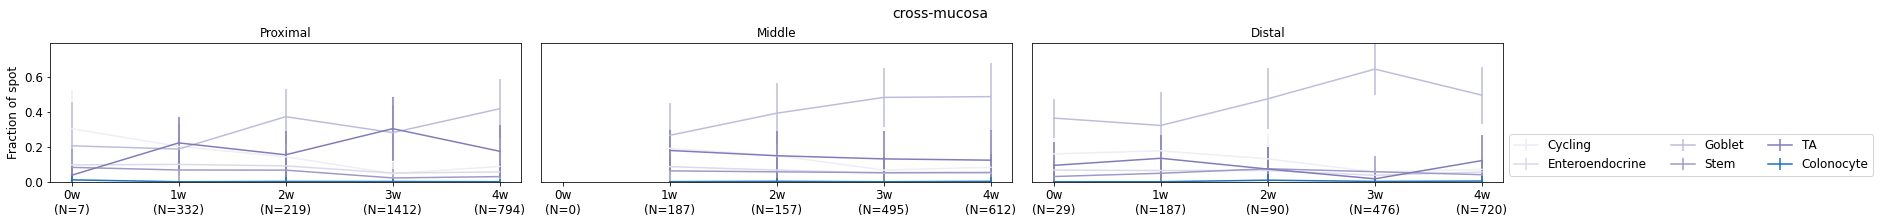

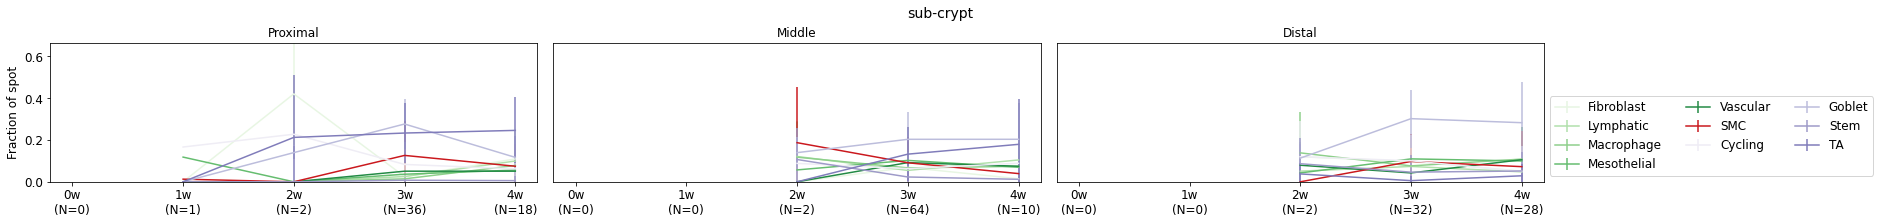

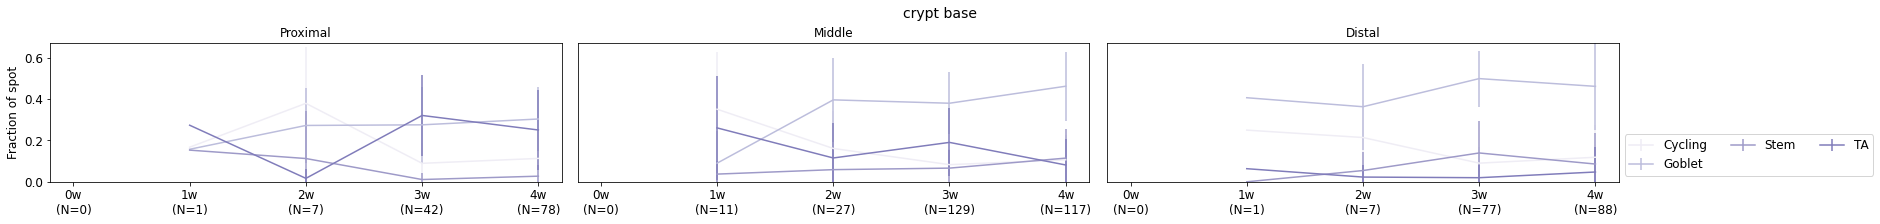

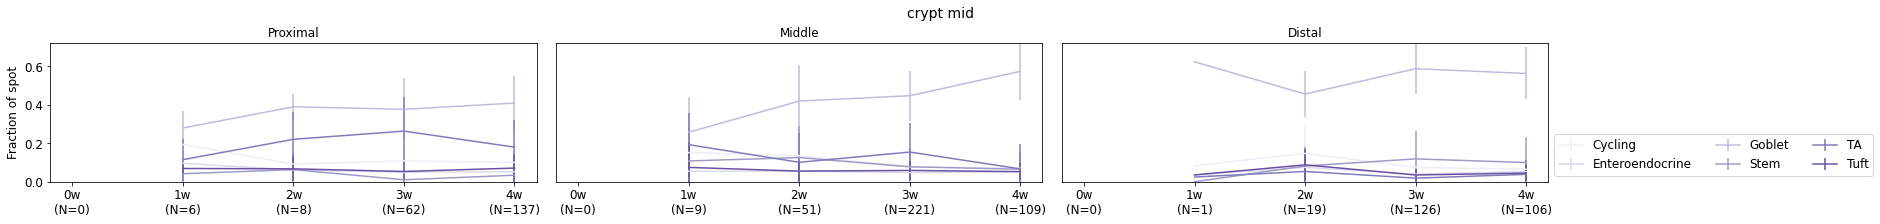

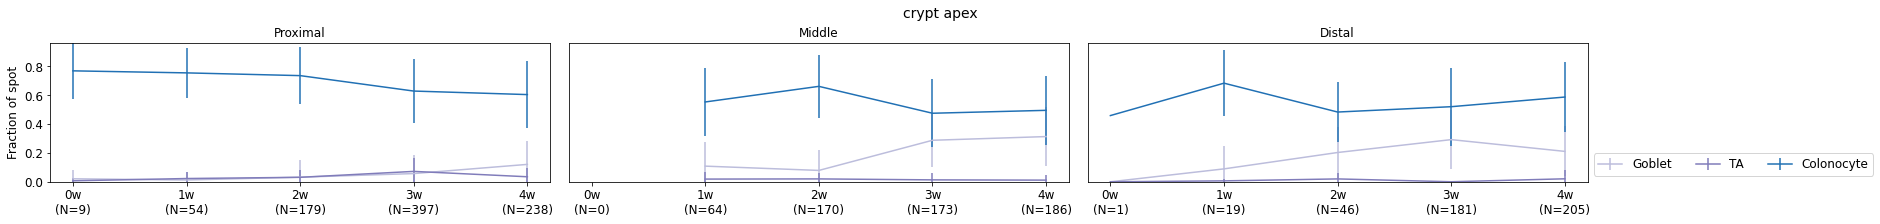

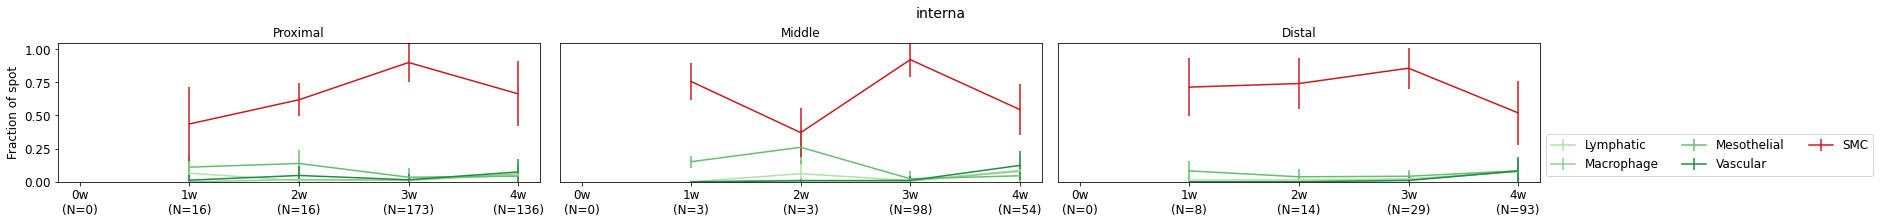

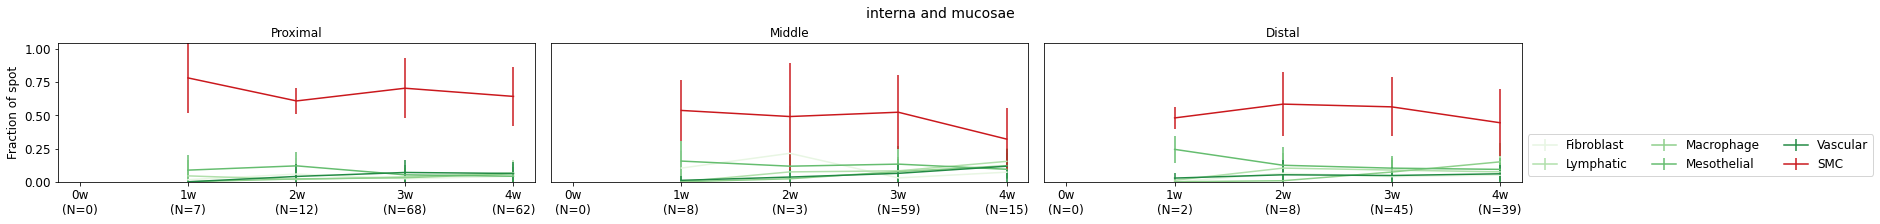

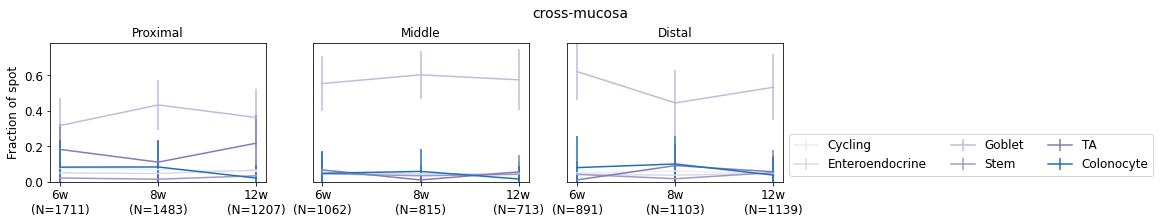

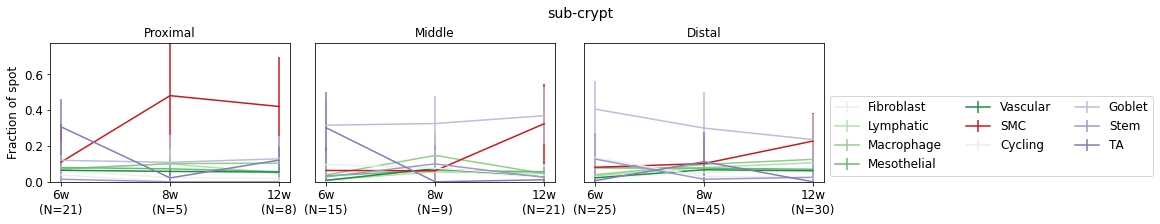

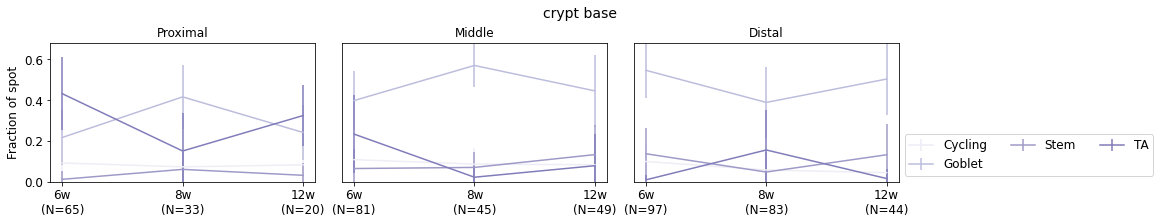

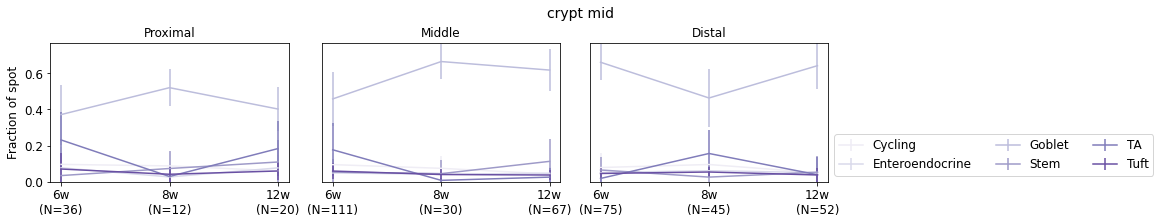

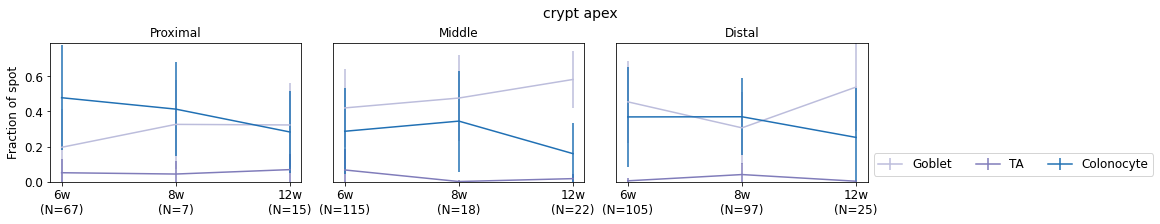

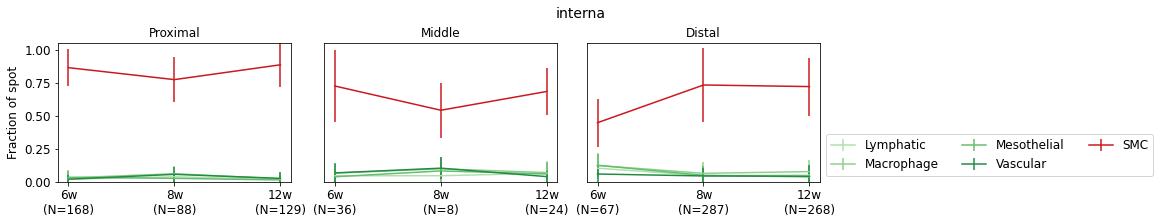

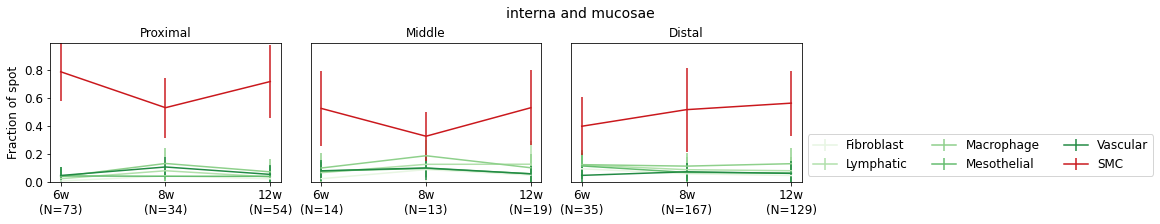

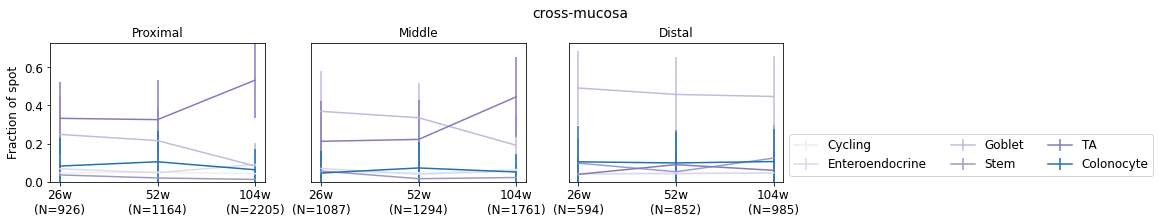

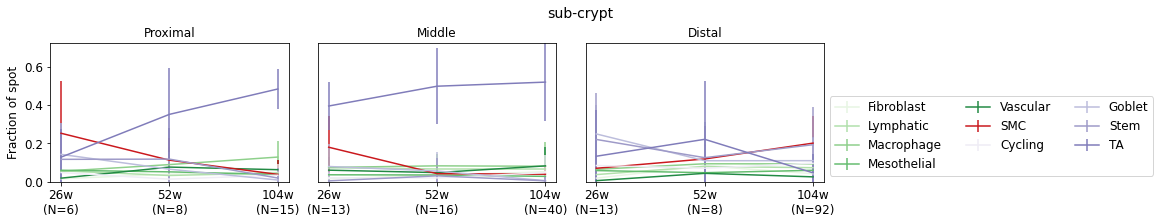

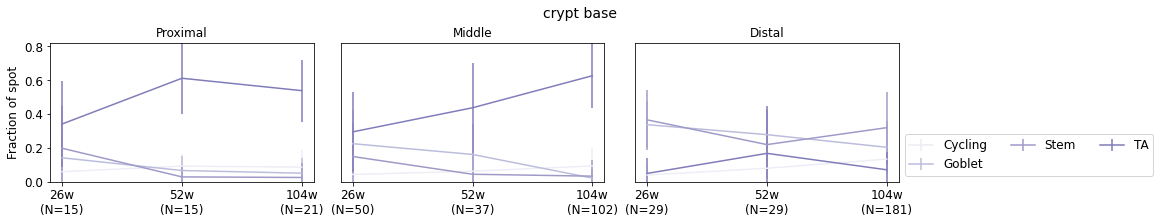

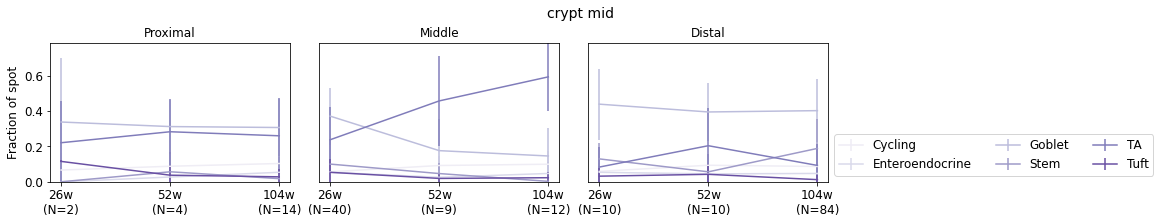

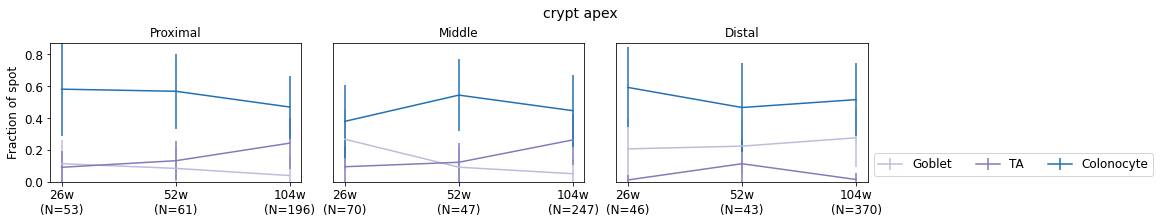

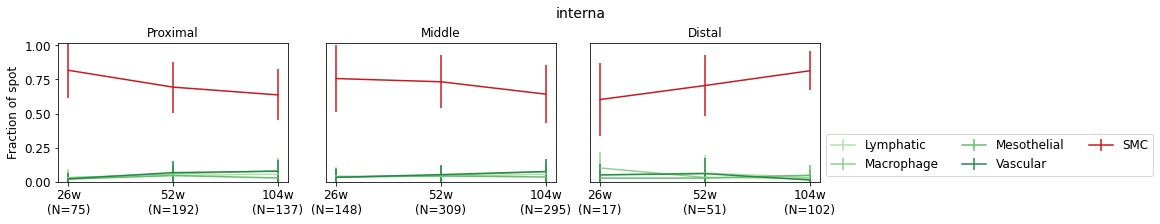

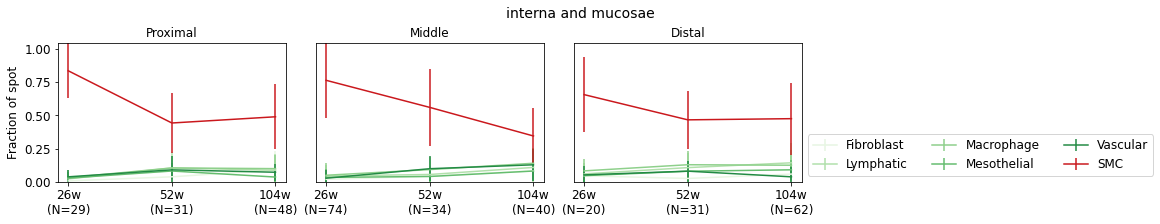

In [6]:
# As above, but restricted to abundant cell types (>5%) and separated into age windows

for t_ordered in [['0w', '1w', '2w', '3w', '4w'], ['6w', '8w', '12w'], ['26w', '52w', '104w']]:
    abundant_thresh = 0.05
    
    t_name = t_ordered[0]+'-'+t_ordered[-1]

    for aar in ['cross-mucosa', 'sub-crypt', 'crypt base', 'crypt mid', 'crypt apex',
            'interna', 'interna and mucosae']:
        obs_aar = adata.obs[adata.obs.annotation == aar]

        fig, ax = plt.subplots(1, 3, figsize=(5*len(t_ordered)+1,3), constrained_layout=True)

        aar_title = aar
        plt.suptitle(aar_title, fontsize=14)

        ymax = np.zeros(3)

        for i, region in enumerate(['Proximal', 'Middle', 'Distal']):
            obs_aar_reg = obs_aar[obs_aar.Region == region]

            celltype_means = dict([(ct, []) for ct in sntypes_ordered])
            celltype_stds = dict([(ct, []) for ct in sntypes_ordered])

            x_labels = []

            for t in t_ordered:
                obs_aar_reg_t = obs_aar_reg[obs_aar_reg.Age == t]
                for ct in sntypes_ordered:
                    celltype_means[ct].append(obs_aar_reg_t[ct].mean())
                    celltype_stds[ct].append(obs_aar_reg_t[ct].std())

                x_labels.append('%s\n(N=%d)' % (t, obs_aar_reg_t.shape[0]))

            ax[i].set_title(region, fontsize=12)

            for ct, col in zip(sntypes_ordered, colors_ordered):
                mean_comp = np.max([obs_aar[ct][obs_aar.Region==r].mean() for r in ['Proximal', 'Middle', 'Distal']])

                ct_lbl = ct
                if ct == 'Myocyte':
                    ct_lbl = 'SMC'

                if mean_comp > abundant_thresh:
                    ax[i].errorbar(np.arange(len(t_ordered)), celltype_means[ct], yerr=celltype_stds[ct], 
                                   label=ct_lbl, color=col)

                    inds = np.logical_not(np.isnan(celltype_stds[ct]))
                    mu = np.array(celltype_means[ct])[inds]
                    sigma = np.array(celltype_stds[ct])[inds]
                    ymax[i] = np.maximum(ymax[i], np.max(mu+sigma))

            ax[i].set_xticks(np.arange(len(t_ordered)))
            ax[i].set_xticklabels(x_labels, fontsize=12)

            if i == 2:
                ax[i].legend(bbox_to_anchor=(1.0, 0), loc='lower left', ncol=3, fontsize=12)

            if i == 0:
                ax[i].set_ylabel('Fraction of spot', fontsize=12)
            else:
                ax[i].set_yticks([])

            ax[i].tick_params(axis='both', which='major', labelsize=12)

        for i in range(3):
            ax[i].set_ylim(0, np.max(ymax))

        plt.show()